In [128]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
from scipy import interpolate

import life_cycle

# Initial example calibration

First, need to find the survival curve:

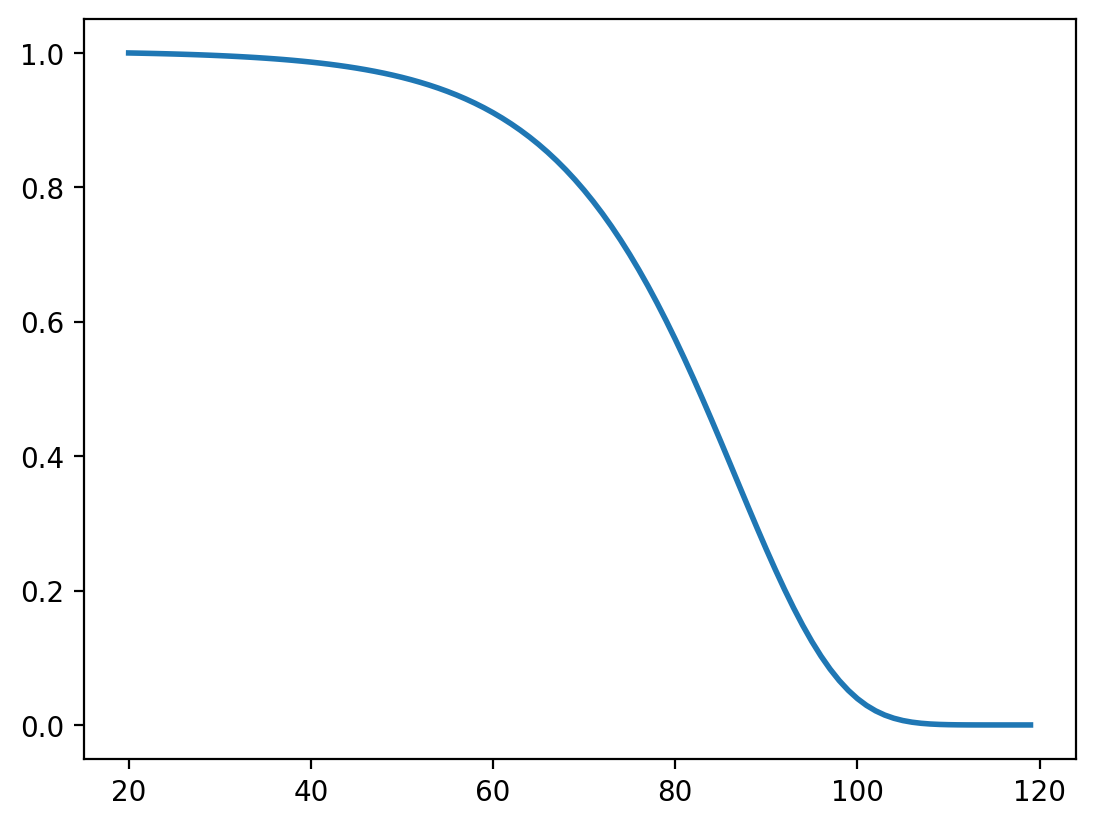

In [129]:
# start at age 20, certain death at 120
J = 120 - 20
age = np.arange(20, 20+J)

# Gompertz parameters that I've found fit the survival curve of the US pretty well
b, c = 0.00025, 0.088
Phi = life_cycle.gompertz_survival(age-20, b, c)
plt.plot(age, Phi, linewidth=2)

For income, a decent approximation (see data in Figure 4 of Auclert, Malmberg, Martenet, Rognlie) is a bell curve that peaks in mid-life, which we'll normalize so that average life-cycle income is 1.

(Note: one weakness with this approximation is that it has too sharp a mid-life peak—we want a bell-like curve that is a bit flatter at the top, but that drops off rapidly at low and high ages. I'm not endorsing this exact functional form, just finding something simple we can use without external data that will get the essence right. Another subtlety is that here weren't looking at the life-cycle, whereas the data in AMMR is cross-sectional, although this doesn't make as big a difference.)

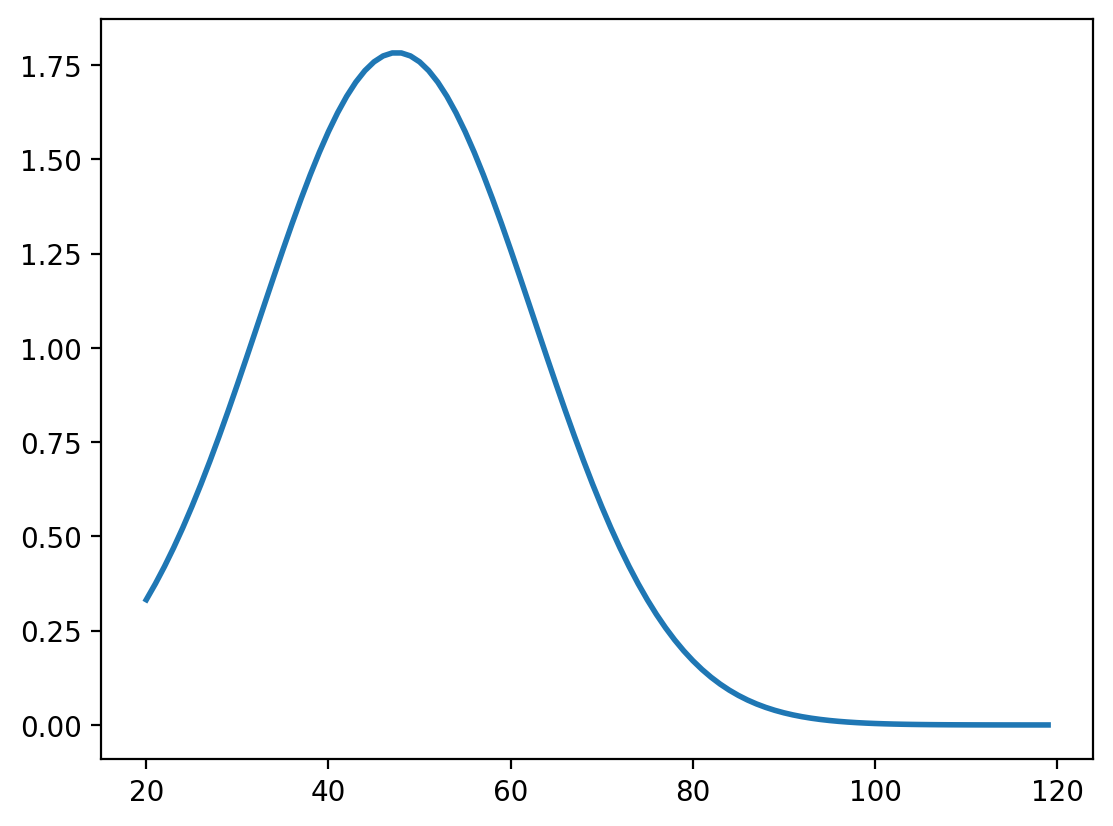

In [130]:
y = np.exp(-((age-47.5)/15)**2 / 2)
y /= ((Phi @ y) / Phi.sum())
plt.plot(age, y,  linewidth=2)

Now we specify the rest of the calibration and call our function to compute the lifecycle for consumption and assets:

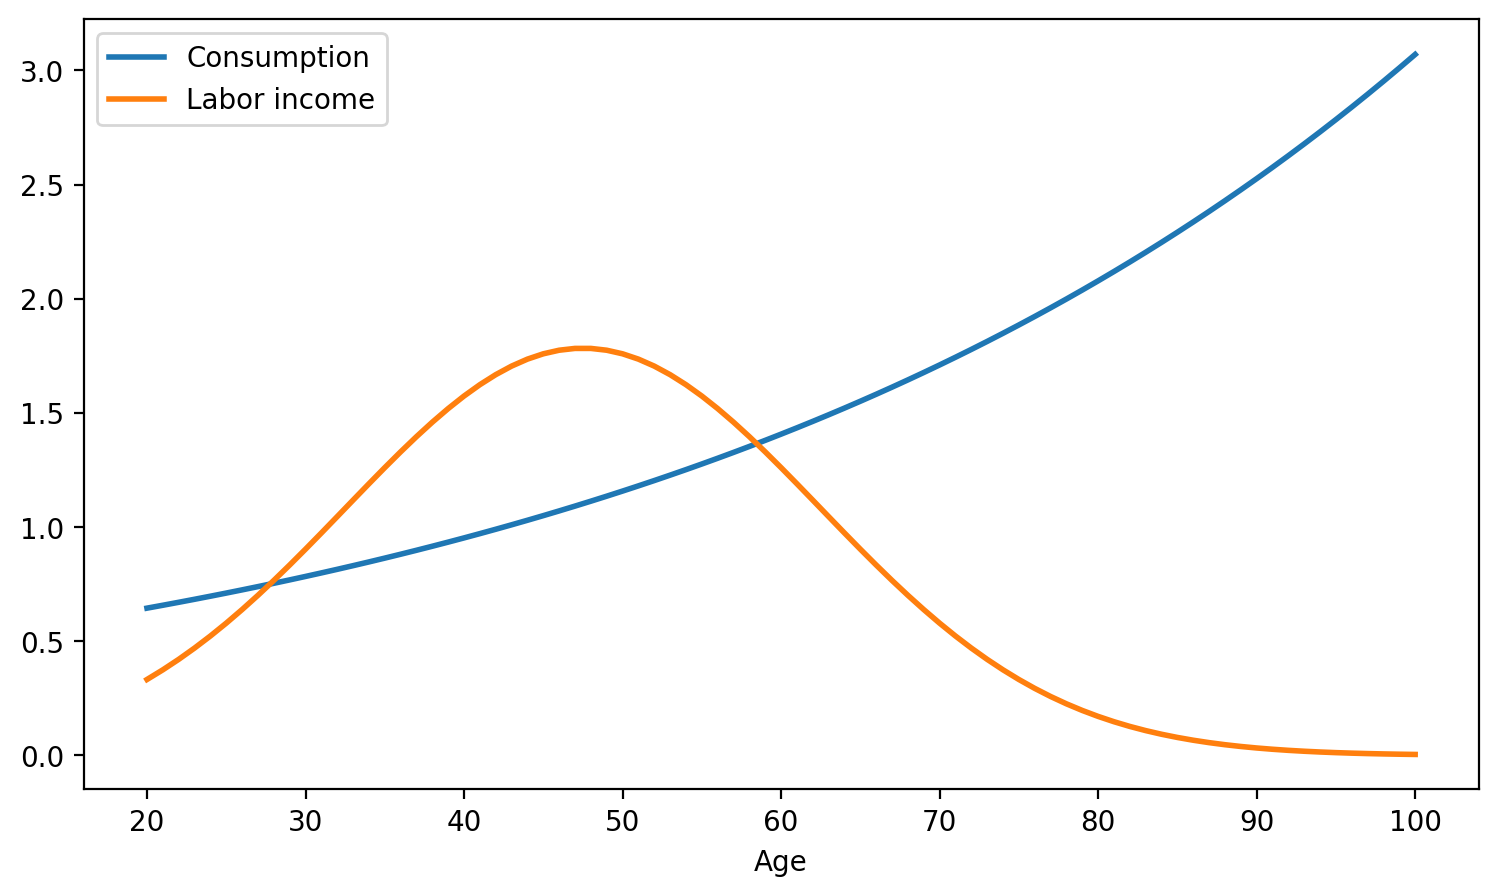

In [131]:
r = 0.03
beta = 0.99**np.arange(J)
sigma = 1
c, a = life_cycle.compute_lifecycle(r, sigma, beta, y, Phi)

plt.figure(figsize=[9, 5])
plt.plot(age[:-19], c[:-19], label='Consumption', linewidth=2)
plt.plot(age[:-19], y[:-19], label='Labor income', linewidth=2)
plt.xlabel('Age')
plt.legend();

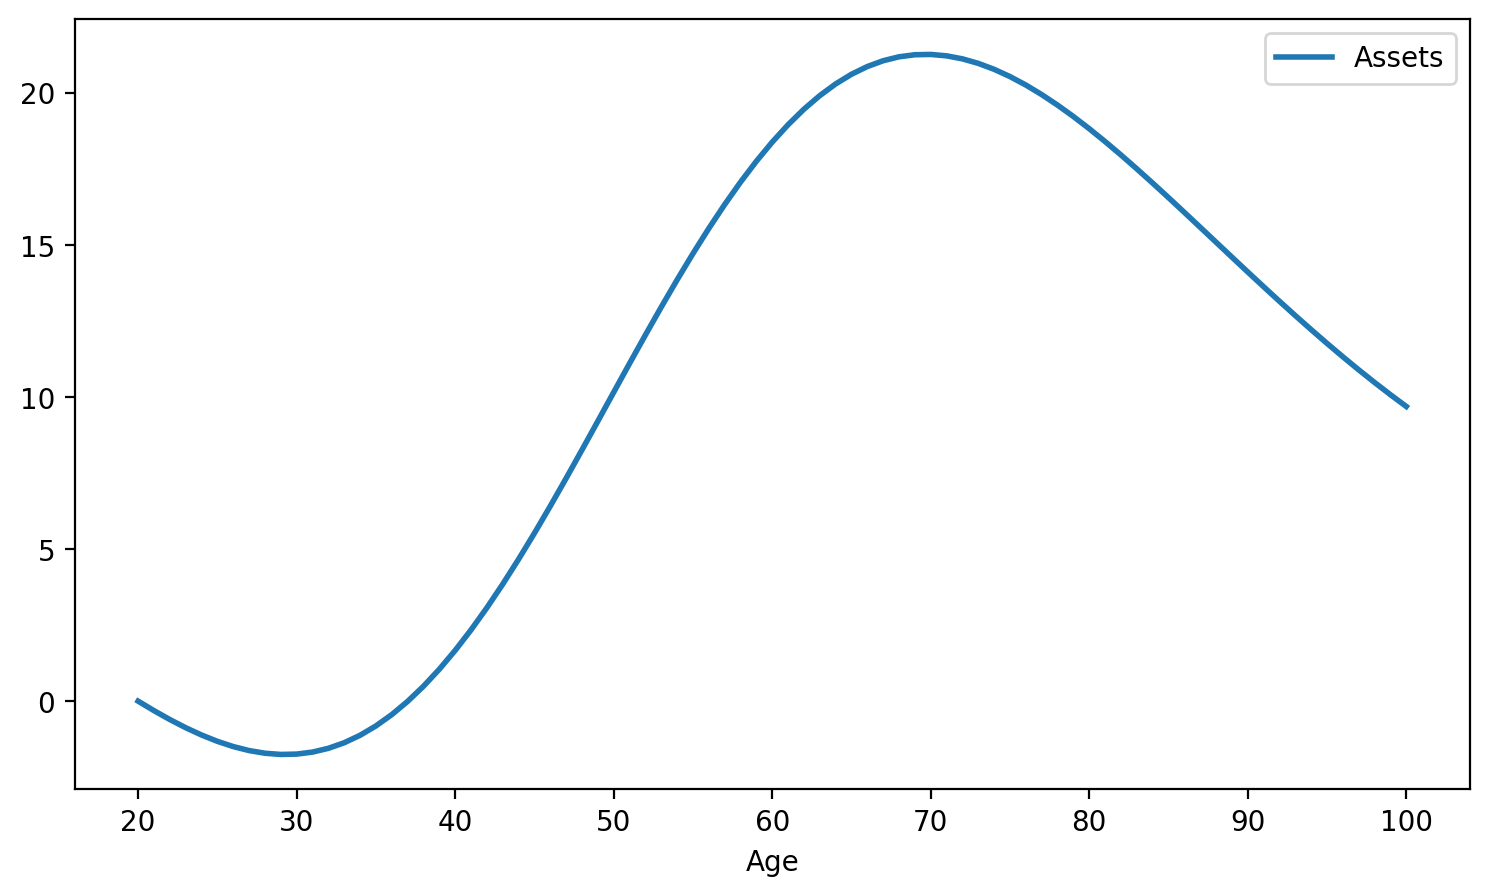

In [132]:
plt.figure(figsize=[9, 5])
plt.plot(age[:-19], a[:-19], label='Assets', linewidth=2)
plt.xlabel('Age')
plt.legend();

# Aggregate assets and interest rates

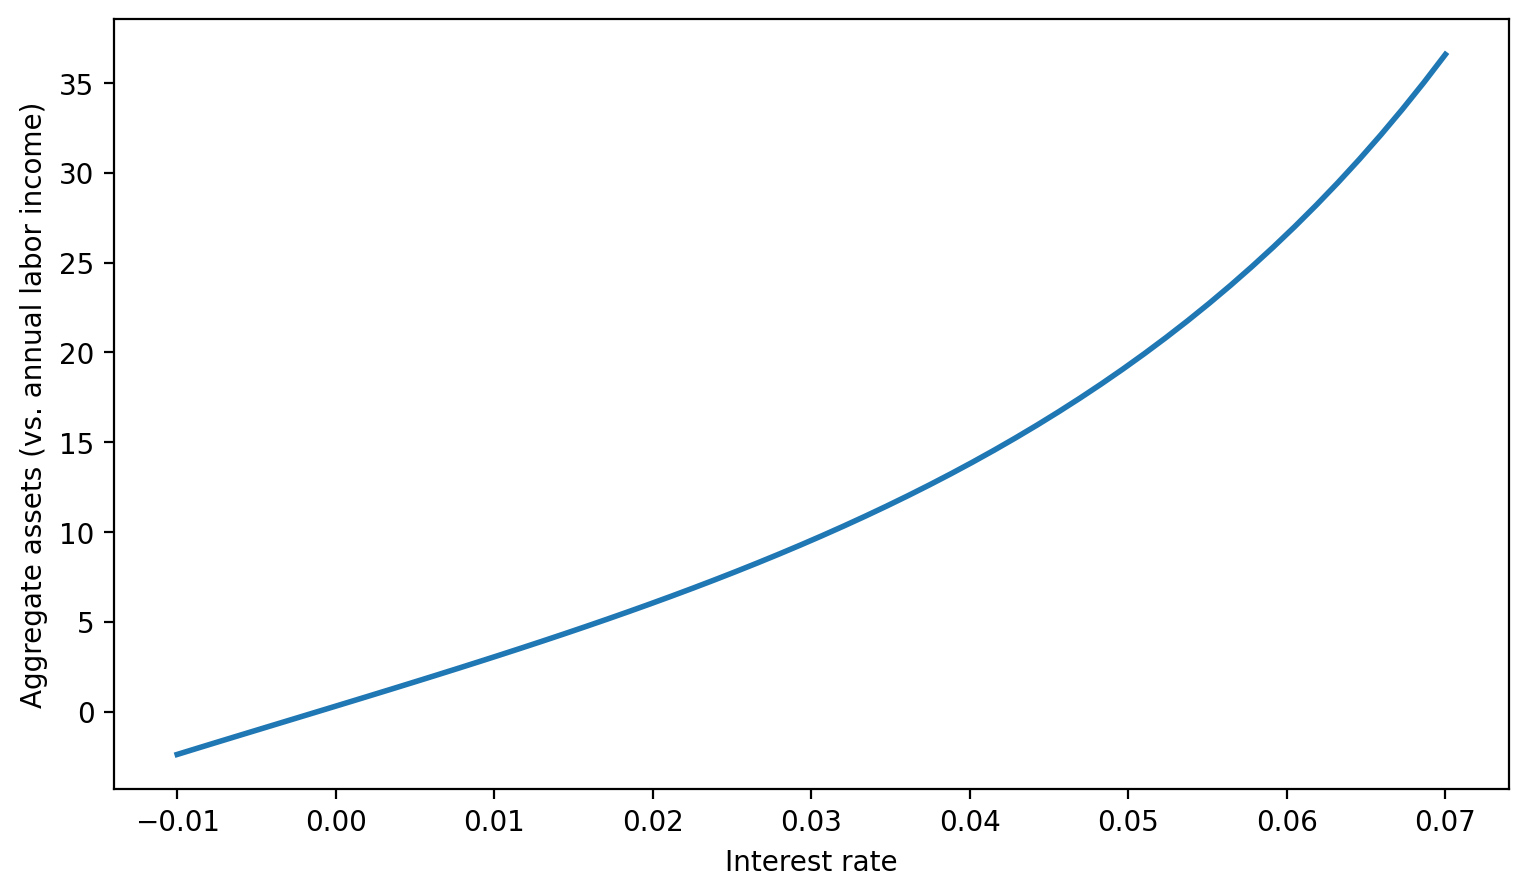

In [133]:
pi = Phi / Phi.sum() # age distribution with zero population growth
rs = np.linspace(-0.01, 0.07, 60)
As = np.array([pi @ life_cycle.compute_lifecycle(r, sigma, beta, y, Phi)[1] for r in rs])

plt.figure(figsize=[9, 5])
plt.plot(rs, As, linewidth=2)
plt.xlabel('Interest rate')
plt.ylabel('Aggregate assets (vs. annual labor income)');

In [134]:
a_r = interpolate.CubicSpline(rs, As)

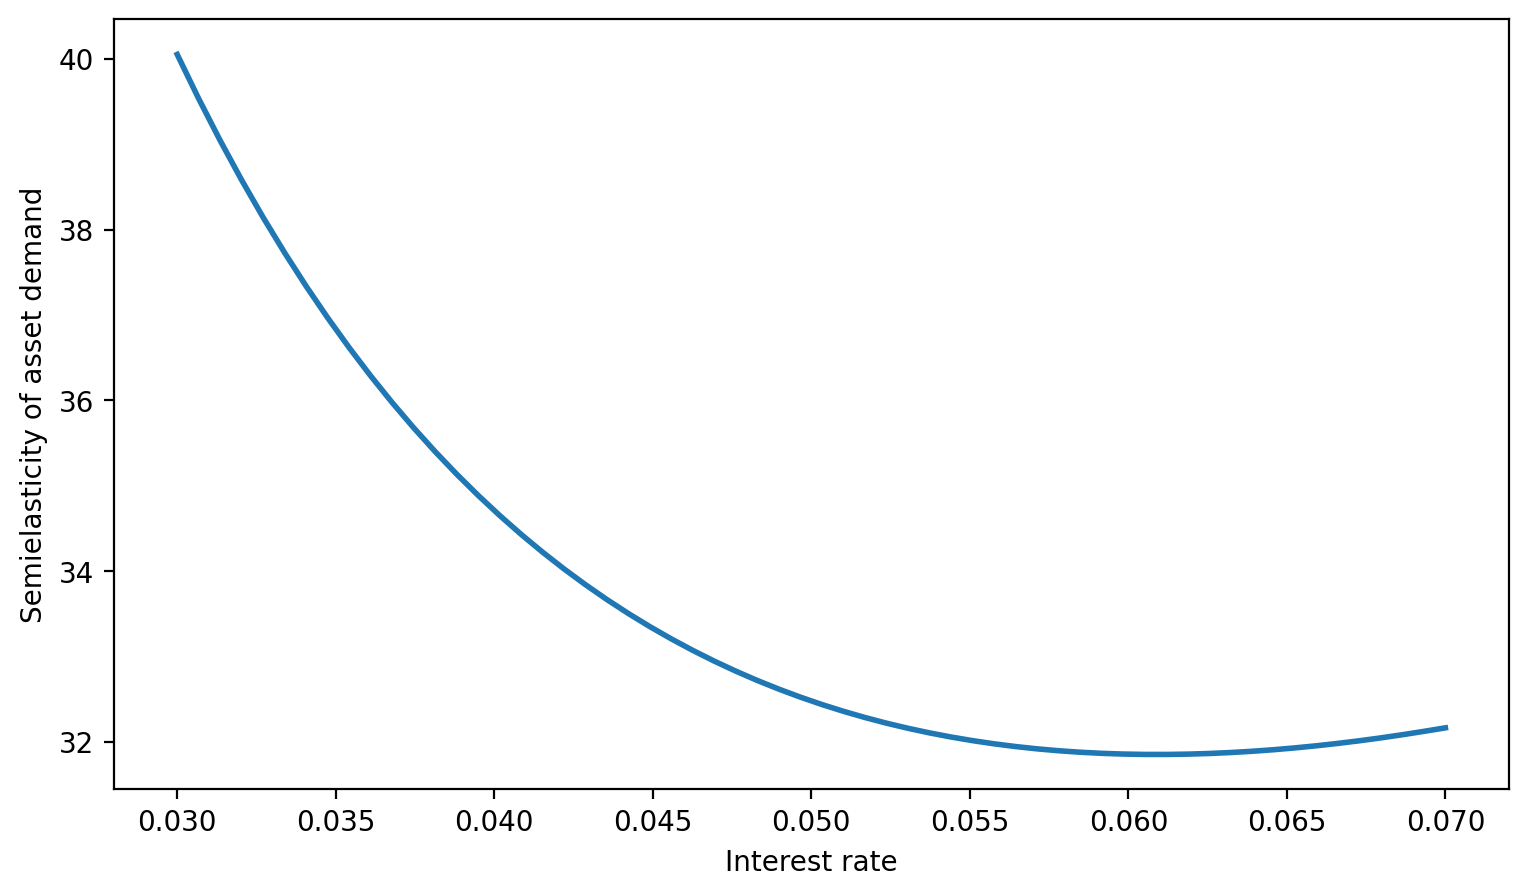

In [135]:
plt.figure(figsize=[9, 5])
rs = np.linspace(0.03, 0.07, 60)
plt.plot(rs, a_r.derivative()(rs) / a_r(rs), linewidth=2)
plt.xlabel('Interest rate')
plt.ylabel('Semielasticity of asset demand');

# Implementing exact sufficient statistic

In [136]:
r = 0.03
c, a = life_cycle.compute_lifecycle(r, sigma, beta, y, Phi)

C, A, Y = pi @ c, pi @ a, pi @ y
pdf_c = (pi*c) / C
pdf_a = (pi*a) / A
pdf_y = (pi*y) / Y

EAge_c = pdf_c @ age
EAge_a = pdf_a @ age
EAge_y = pdf_y @ age
EAge_c, EAge_a, EAge_y

(59.32633795398422, 67.64721766681166, 47.407539348198746)

In [137]:
VarAge_c = pdf_c @ (age - EAge_c)**2
C/A, VarAge_c, sigma*C/A*VarAge_c

(0.13484499593593666, 400.4782373206476, 54.002486283933806)

In [138]:
EAge_c, EAge_a, EAge_c - EAge_a

(59.32633795398422, 67.64721766681166, -8.320879712827434)

In [139]:
eps_d_sub_formula = sigma*C/A*VarAge_c
eps_d_inc_formula = EAge_c - EAge_a
eps_d_formula = eps_d_sub_formula + eps_d_inc_formula
eps_d_formula

45.68160657110637

In [140]:
eps_d_actual = a_r.derivative()(r) / a_r(r)
eps_d_actual

40.05126191371137

### What if we had EIS=0.5?

In [141]:
sigma = 0.5
sens_d_actual = (pi @ life_cycle.compute_lifecycle(r+1E-3, sigma, beta, y, Phi)[1] - pi @ life_cycle.compute_lifecycle(r-1E-3, sigma, beta, y, Phi)[1])/2E-3
sens_d_actual

106.03547807323066

In [142]:
c, a = life_cycle.compute_lifecycle(r, sigma, beta, y, Phi)

C, A, Y = pi @ c, pi @ a, pi @ y
pdf_c = (pi*c) / C
pdf_a = (pi*a) / A
pdf_y = (pi*y) / Y

EAge_c = pdf_c @ age
EAge_a = pdf_a @ age
EAge_y = pdf_y @ age
EAge_c, EAge_a, EAge_y

(55.397277706178414, 74.92109202084754, 47.407539348198746)

In [143]:
eps_d_actual = sens_d_actual / A
eps_d_actual

21.044742653602437